# Fourier Tranform (FFT) in Jupyter

### Import packages

In [4]:
import numpy as np # widely used python library for data manipulation, the 'as' allows you to rename the package on import
from scipy import constants  # this is how you just get specific subpackages or functions
import pandas as pd
import json, yaml
import sys # get some information about the current OS
from pathlib import Path
import matplotlib.pyplot as plt



### Define Mesh

#### Mesh as Class Object

In [5]:
class Mesh(object):
    def __init__(self, fmax, df):
        self.fmax = fmax
        self.df=df
        self.f=np.arange(-self.fmax,self.fmax+self.df,self.df)
        self.npoints=len(self.f)
        self.tmax=1/(2*self.df)
        self.t=np.linspace(-self.tmax,self.tmax,self.npoints)
        self.dt=np.abs(self.t[1]-self.t[0])       
        
        
mesh=Mesh(1000e12,1e11)

#### Define pulse as Class Object

Text(0, 0.5, 'f(t)')

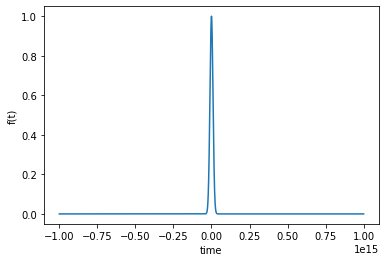

In [7]:
class Pulse(object):
    def __init__(self,mesh, t_pulse):
        self.Et = np.exp(-(mesh.t/(2*t_pulse))**2)
  
pulse=Pulse(mesh,35e-15)
pulse.Et

plt.plot(mesh.f,pulse.Et)
plt.xlabel('time')
plt.ylabel('f(t)')

### Interactive Gaussian pulse in time

In [9]:
from ipywidgets import interact
import numpy as np
from edaipynb.tools.notebook import restart_kernel
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
output_notebook()

# Init
my_gauss = lambda t, t_pulse : np.exp(-(t/(2*t_pulse))**2)
my_gaussf= lambda t, t_pulse : np.abs(np.fft.fftshift(np.fft.fft(np.exp(-(t/(2*t_pulse))**2))))
mesh=Mesh(1000e12,1e11)

y=my_gauss(mesh.t,35e-15)


p = figure(title="simple pulse", plot_height=300, plot_width=600, x_range=(-500,500),
           background_fill_color='#efefef')
r = p.line(mesh.t*1e15, y, color="#8888cc", line_width=1.5, alpha=0.8)

def update(f, duration=35):
    if   f == "time": 
            func = my_gauss
            x = mesh.t
    if f == "frequency": 
            func = my_gaussf
            x = mesh.f
    r.data_source.data['y'] = func(mesh.t,duration*1e-15)
    push_notebook()



show(p, notebook_handle=True)

interact(update, f=['time','frequency'], duration=(10,100),ylim=(1,500))

Loading BokehJS ...

interactive(children=(Dropdown(description='f', options=('time', 'frequency'), value='time'), IntSlider(value=…

<function __main__.update(f, duration=35)>

In [ ]:
mesh= dict(
        fmax=500e12,
        f=np.linspace(-fmax,fmax,10000),
        df=f[1]-f[0]
)
mesh['df']

### Interactive plots for visualization

In [10]:
from ipywidgets import interact
import numpy as np
from edaipynb.tools.notebook import restart_kernel
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
output_notebook()

x = np.linspace(0, 2*np.pi, 2000)
y = np.sin(x)

p = figure(title="simple line example", plot_height=300, plot_width=600, y_range=(-5,5),
           background_fill_color='#efefef')
r = p.line(x, y, color="#8888cc", line_width=1.5, alpha=0.8)

def update(f, w=1, A=1, phi=0):
    if   f == "sin": func = np.sin
    elif f == "cos": func = np.cos
    r.data_source.data['y'] = A * func(w * x + phi)
    push_notebook()


show(p, notebook_handle=True)

interact(update, f=["sin", "cos"], w=(0,50), A=(1,10), phi=(0, 20, 0.1))

Loading BokehJS ...

interactive(children=(Dropdown(description='f', options=('sin', 'cos'), value='sin'), IntSlider(value=1, descr…

<function __main__.update(f, w=1, A=1, phi=0)>

# Use Chirplet Transform package

In [11]:
str(Path.home())

'/Users/ityulnev'

In [33]:
sys.path = [str(Path.home()/'PycharmProjects')]
#sys.path = [str('/PycharmProjects/chirplet')]
import chirplet as cp



In [32]:
cp.

SyntaxError: invalid syntax (<ipython-input-32-b88e8b53f880>, line 1)

In [372]:
import numpy as np
from scipy.signal import hilbert
from scipy.fftpack import fft, fftfreq

def gaussian_chirplet(t, alpha1=1., alpha2=0., beta=2., fc=1., phi=0., tau=0.):
    """Gaussian chirplet function given input parameters

    Keyword arguments:
    t -- time vector
    alpha1 -- bandwidth factor
    alpha2 -- chirp-rate
    beta -- amplitude
    fc -- center frequency
    phi -- phase
    tau -- time of arrival

    Return values:
    y -- chirplet

    Reference: Yufeng Lu, Ramazan Demirli, Guilherme Cardosa, and Jafar Saniie,
    "A Successive Parameter estimation Algorithm for Chirplet Signal
    Decomposition," IEEE Trans. UFFC, vol 53, no 11, November 2006.

    """

    y = beta * np.exp(-alpha1 * (t-tau) ** 2 + 1j * 2 * np.pi * fc * (t - tau)
        + 1j * phi + 1j * alpha2 * (t - tau) ** 2)
    
    return y

def estimate_gaussian_chirplet_parameters(y, t):
    """Estimate Gaussian chriplet parameters for the provided signal segment.
    Parameters are estimated in the following order:

    tau, beta, phi, fc, alpha2, alpha1

    Keyword arguments:
    y -- signal segment
    t -- time vector

    Return values:
    parameters -- dictionary of parameter values
        alpha1 -- bandwidth factor
        alpha2 -- chirp-rate
        beta -- amplitude
        fc -- center frequency
        phi -- phase
        tau -- time of arrival

    """

    # Determine sampling frequency
    dt = t[1] - t[0]
    fs = 1 / dt

    # Estimate tau and beta from envelope
    env = abs(hilbert(y))
    index = np.argmax(env)
    tau = t[index]
    beta = env[index]

    # Estimate phi using tau
    analytic = hilbert(y)
    phi = phase(analytic[index] / beta)

    # Estimate center frequency by finding peak in spectrum
    S = abs(fft(y))
    freq = fftfreq(S.size) * fs
    index = np.argmax(S)
    fc = freq[index]

    # Estimate alpha2 (chirp rate)
    N = 2 ** 7
    coefs = np.zeros(N)
    for i, alpha2 in enumerate(np.linspace(0, 2, N)):
        kernel = np.real(gaussian_chirplet(t, alpha1=1.0, alpha2=alpha2,
            beta=beta, fc=fc, phi=phi, tau=tau))
        kernel = kernel / np.sqrt(np.sum(kernel ** 2))
        coefs[i] = y.dot(kernel)

    index = np.argmax(np.real(coefs))
    alpha2 = np.linspace(0, 2, N)[index]

    # Estimate alpha1 (bandwidth factor)
    N = 2 ** 7
    coefs = np.zeros(N)
    for i, alpha1 in enumerate(np.linspace(0, 2, N)):
        kernel = np.real(gaussian_chirplet(t, alpha1=alpha1,
            alpha2=alpha2, beta=beta, fc=fc, phi=phi, tau=tau))
        kernel = kernel / np.sqrt(np.sum(kernel ** 2))
        coefs[i] = y.dot(kernel)

    index = np.argmax(np.real(coefs))
    alpha1 = np.linspace(0, 2, N)[index]

    return {'alpha1':alpha1, 'alpha2':alpha2, 'beta':beta, 'fc':fc, 'phi':phi, 'tau':tau}

In [342]:
from chirplet import gaussian_chirplet, estimate_gaussian_chirplet_parameters

ImportError: cannot import name 'gaussian_chirplet' from 'chirplet' (unknown location)

In [1]:
# Install a conda package in the current Jupyter kernel
import sys
!conda install --yes --prefix {sys.prefix} cmath



Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.

PackagesNotFoundError: The following packages are not available from current channels:

  - cmath

Current channels:

  - https://repo.anaconda.com/pkgs/main/osx-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/osx-64
  - https://repo.anaconda.com/pkgs/r/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.




In [377]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install cmath



  ERROR: Could not find a version that satisfies the requirement cmath (from versions: none)
ERROR: No matching distribution found for cmath


In [2]:
sys.prefix

'/Users/ityulnev/opt/anaconda3'